# Time-Series (LSTM) US COVID Confirmed Cases Forecasting

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import shapiro
import warnings

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings("ignore")
from keras import backend as K
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


df = pd.read_csv("C:\\Users\\Samir Prasun\\Desktop\\Data Incubator\\time-series-covid19.csv")

df.drop(["Lat","Long","Province/State"], axis=1, inplace=True)
np.where(pd.isnull(df))

df=df.dropna(how='any')
print(np.where(pd.isnull(df)))
df.describe()


(array([], dtype=int64), array([], dtype=int64))


Using TensorFlow backend.


,Confirmed,Recovered,Deaths
count,21165.000000,21165.000000,21165.000000
mean,1555.128798,379.898748,83.337586
std,15005.231066,3635.384506,913.134378
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,120.000000,10.000000,1.000000
max,636350.000000,72600.000000,28326.000000


In [3]:
confirmed_US = df[df['Country/Region']=='US'].groupby(['Date']).agg({'Confirmed':['sum']})
fatalities_US = df[df['Country/Region']=='US'].groupby(['Date']).agg({'Deaths':['sum']})

dataset1=df[df['Country/Region']=='US'].Confirmed.values

#date= np.array('2020-04-10', dtype=np.datetime64)
#Date=date + np.arange(23)

#date1= np.array('2020-01-22', dtype=np.datetime64)
#Date1=date1 + np.arange(85)

#date2= np.array('2020-01-22', dtype=np.datetime64)
#Date2=date2 + np.arange(80)


[1.00000e+00 1.00000e+00 2.00000e+00 2.00000e+00 5.00000e+00 5.00000e+00
 5.00000e+00 5.00000e+00 5.00000e+00 7.00000e+00 8.00000e+00 8.00000e+00
 1.10000e+01 1.10000e+01 1.10000e+01 1.10000e+01 1.10000e+01 1.10000e+01
 1.10000e+01 1.10000e+01 1.20000e+01 1.20000e+01 1.30000e+01 1.30000e+01
 1.30000e+01 1.30000e+01 1.30000e+01 1.30000e+01 1.30000e+01 1.30000e+01
 1.50000e+01 1.50000e+01 1.50000e+01 5.10000e+01 5.10000e+01 5.70000e+01
 5.80000e+01 6.00000e+01 6.80000e+01 7.40000e+01 9.80000e+01 1.18000e+02
 1.49000e+02 2.17000e+02 2.62000e+02 4.02000e+02 5.18000e+02 5.83000e+02
 9.59000e+02 1.28100e+03 1.66300e+03 2.17900e+03 2.72700e+03 3.49900e+03
 4.63200e+03 6.42100e+03 7.78300e+03 1.37470e+04 1.92730e+04 2.56000e+04
 3.32760e+04 4.38470e+04 5.37400e+04 6.57780e+04 8.38360e+04 1.01657e+05
 1.21465e+05 1.40909e+05 1.61831e+05 1.88172e+05 2.13372e+05 2.43762e+05
 2.75586e+05 3.08853e+05 3.37072e+05 3.66667e+05 3.96223e+05 4.29052e+05
 4.61437e+05 4.96535e+05 5.26396e+05 5.55313e+05 5.

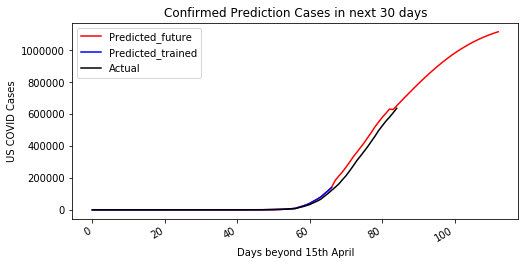

In [4]:
from sklearn.metrics import r2_score
#dataset=confirmed_US.sum
print(dataset1)
dataset = dataset1.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range = (0, 1))

dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]


print (test.shape)

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        X.append(a)
        b = (dataset[(i + look_back)])
        Y.append(b)
    return np.array(X), np.array(Y)
    
look_back = 1
H = 20
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back,1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back,1))


lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(look_back, 1)))
lstm_model.add(Dense(10, activation='relu'))

#lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')

from tensorflow.keras.callbacks import EarlyStopping
early_Stop = EarlyStopping(monitor='loss', patience = 20, restore_best_weights=True)


lstm_model.fit(X_train, Y_train, epochs=100, callbacks=[early_Stop], batch_size=1)



train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

#train_predict = np.reshape(train_predict, (train_predict.shape[0], 1, 1))
#test_predict = np.reshape(test_predict, (test_predict.shape[0], 1, 1))
print(r2_score(train_predict, X_train[:,0,0]))
print(r2_score(test_predict, X_test[:,0,0]))


test_new = np.reshape(test_predict, (test_predict.shape[0], 1, 1))
future = []


currentStep = test_new[-2:-1,:,:]
for i in range(30):
    currentStep = lstm_model.predict(currentStep)
    future.append(currentStep)
    currentStep = np.reshape(currentStep, (currentStep.shape[0],look_back, 1))
       
lstm_model.reset_states()

Fut=np.array(future)
print(Fut.shape)
Fut = np.reshape(Fut, (Fut.shape[0], 1))
Confirmed_new=scaler.inverse_transform(np.array(Fut))


train_predict_actual = scaler.inverse_transform(train_predict)
test_predict_actual = scaler.inverse_transform(test_predict)

Predicted = np.concatenate([train_predict_actual,test_predict_actual,Confirmed_new])

fig1 = plt.figure(figsize=(8,4))
plt.plot(Predicted, color='red', label='Predicted_future')
plt.plot(train_predict_actual, color='blue', label='Predicted_trained')
plt.plot(dataset1, color='black', label='Actual')

plt.title('Confirmed Prediction Cases in next 30 days')
plt.xlabel('Days beyond 15th April')
plt.ylabel('US COVID Cases')
fig1.autofmt_xdate()
plt.legend()
plt.show()


# Observations
### 1) The plot reveals the US covid actual data fits well with trained data
### 2) Future prediction reveals that in the next 30 days, the increase in confirmed cases would somewhat reduce, more tending towards curve flattening. This is a good news for US.